In [ ]:
from google.colab import files
files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


{'test.csv': b'id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds\n15289,25.0,0.25,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.39936701,0.408088064,31.39456852\n15290,12.5,0.25,0.25,0.75,0.63,94.6,57.2,79.0,68.2,33.0,55.9,1.0,0.1,0.488047919,0.442865602,36.8469565\n15291,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.583378727,0.487056813,40.03764422\n15292,25.0,0.5,0.38,0.38,0.63,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.433014308,0.4228466,33.11609108\n15293,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,24.0,0.39,0.36099568,0.388860282,29.55801912\n15294,12.5,0.25,0.25,0.75,0.75,94.6,57.2,79.0,68.2,33.0,55.9,34.0,0.56,0.451910565,0.435620773,32.81456057\n15295,12.5,0.25,0.25,0.75,0.63,77.4,46.8,64.7,55.8,27.0,45.8,16.0,0.26,0.572611128,0.482118713,40.16166766\n15296,12.5,0.25,0.38,0.5,0

In [ ]:
!pip install catboost
!pip install optuna
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from prophet import Prophet
from tqdm.notebook import trange, tqdm
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, sum_models
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.model_selection import StratifiedKFold, KFold
from statsmodels.api import datasets
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.7 MB/s eta 0:00:00


In [ ]:
data_test = pd.read_csv('test.csv')
display(data_test.head())
data_test.info()

id  clonesize  honeybee  bumbles  andrena  osmia  MaxOfUpperTRange  \
0  15289       25.0      0.25     0.25     0.25   0.25              86.0   
1  15290       12.5      0.25     0.25     0.75   0.63              94.6   
2  15291       12.5      0.25     0.25     0.63   0.63              86.0   
3  15292       25.0      0.50     0.38     0.38   0.63              86.0   
4  15293       37.5      0.75     0.25     0.25   0.25              94.6   

   MinOfUpperTRange  AverageOfUpperTRange  MaxOfLowerTRange  MinOfLowerTRange  \
0              52.0                  71.9              62.0              30.0   
1              57.2                  79.0              68.2              33.0   
2              52.0                  71.9              62.0              30.0   
3              52.0                  71.9              62.0              30.0   
4              57.2                  79.0              68.2              33.0   

   AverageOfLowerTRange  RainingDays  AverageRainingDays  fruitset  fruitmass  \
0                  50.8         24.0                0.39  0.399367   0.408088   
1                  55.9          1.0                0.10  0.488048   0.442866   
2                  50.8         16.0                0.26  0.583379   0.487057   
3                  50.8         16.0                0.26  0.433014   0.422847   
4                  55.9         24.0                0.39  0.360996   0.388860   

       seeds  
0  31.394569  
1  36.846956  
2  40.037644  
3  33.116091  
4  29.558019

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10194 entries, 0 to 10193
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10194 non-null  int64  
 1   clonesize             10194 non-null  float64
 2   honeybee              10194 non-null  float64
 3   bumbles               10194 non-null  float64
 4   andrena               10194 non-null  float64
 5   osmia                 10194 non-null  float64
 6   MaxOfUpperTRange      10194 non-null  float64
 7   MinOfUpperTRange      10194 non-null  float64
 8   AverageOfUpperTRange  10194 non-null  float64
 9   MaxOfLowerTRange      10194 non-null  float64
 10  MinOfLowerTRange      10194 non-null  float64
 11  AverageOfLowerTRange  10194 non-null  float64
 12  RainingDays           10194 non-null  float64
 13  AverageRainingDays    10194 non-null  float64
 14  fruitset              10194 non-null  float64
 15  fruitmass          

In [ ]:
data_train = pd.read_csv('train.csv')
display(data_train.head())
data_train.info()

id  clonesize  honeybee  bumbles  andrena  osmia  MaxOfUpperTRange  \
0   0       25.0      0.50     0.25     0.75   0.50              69.7   
1   1       25.0      0.50     0.25     0.50   0.50              69.7   
2   2       12.5      0.25     0.25     0.63   0.63              86.0   
3   3       12.5      0.25     0.25     0.63   0.50              77.4   
4   4       25.0      0.50     0.25     0.63   0.63              77.4   

   MinOfUpperTRange  AverageOfUpperTRange  MaxOfLowerTRange  MinOfLowerTRange  \
0              42.1                  58.2              50.2              24.3   
1              42.1                  58.2              50.2              24.3   
2              52.0                  71.9              62.0              30.0   
3              46.8                  64.7              55.8              27.0   
4              46.8                  64.7              55.8              27.0   

   AverageOfLowerTRange  RainingDays  AverageRainingDays  fruitset  fruitmass  \
0                  41.2         24.0                0.39  0.425011   0.417545   
1                  41.2         24.0                0.39  0.444908   0.422051   
2                  50.8         24.0                0.39  0.552927   0.470853   
3                  45.8         24.0                0.39  0.565976   0.478137   
4                  45.8         24.0                0.39  0.579677   0.494165   

       seeds       yield  
0  32.460887  4476.81146  
1  33.858317  5548.12201  
2  38.341781  6869.77760  
3  39.467561  6880.77590  
4  40.484512  7479.93417

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15289 entries, 0 to 15288
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    15289 non-null  int64  
 1   clonesize             15289 non-null  float64
 2   honeybee              15289 non-null  float64
 3   bumbles               15289 non-null  float64
 4   andrena               15289 non-null  float64
 5   osmia                 15289 non-null  float64
 6   MaxOfUpperTRange      15289 non-null  float64
 7   MinOfUpperTRange      15289 non-null  float64
 8   AverageOfUpperTRange  15289 non-null  float64
 9   MaxOfLowerTRange      15289 non-null  float64
 10  MinOfLowerTRange      15289 non-null  float64
 11  AverageOfLowerTRange  15289 non-null  float64
 12  RainingDays           15289 non-null  float64
 13  AverageRainingDays    15289 non-null  float64
 14  fruitset              15289 non-null  float64
 15  fruitmass          

In [ ]:
# data_train = data_train.drop(['id', 'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange', 'MaxOfLowerTRange', 'AverageOfLowerTRange', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds'], axis=1)
# data_train = data_train.drop(['id','MinOfLowerTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange', 'MaxOfLowerTRange', 'MaxOfUpperTRange', 'RainingDays'], axis=1)
#MAX COP

In [ ]:
data_train.AverageOfLowerTRange.value_counts()

50.8    4200
45.8    3787
55.9    3735
41.2    3564
45.3       3
Name: AverageOfLowerTRange, dtype: int64

In [ ]:
# data_train = data_train.query('clonesize != 40.0 and clonesize != 10.0')
# data_train = data_train.query('honeybee != 18.430 and honeybee != 6.640 and honeybee != 0.000')
# # data_train.bumbles = data_train.bumbles.replace(0.260, 0.250)
# data_train = data_train.query('bumbles != 0.260 and bumbles != 0.560 and bumbles != 0.293 and bumbles != 0.585 and bumbles != 0.065 and bumbles != 0.058 and bumbles != 0.042 and bumbles != 0.000')
# data_train = data_train.query('andrena != 0.147 and andrena != 0.560 and andrena != 0.240 and andrena != 0.000 and andrena != 0.229 and andrena != 0.490')
# data_train = data_train.query('osmia != 0.606 and osmia != 0.078 and osmia != 0.020 and osmia != 0.620')
# data_train = data_train.query('AverageOfLowerTRange != 45.3')
# data_train = data_train.query('AverageRainingDays != 0.25 and AverageRainingDays != 0.14')

In [ ]:
to_cat = ['clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia', 'AverageOfLowerTRange', 'AverageRainingDays']
for cat in to_cat:
    unique_values = np.unique(np.concatenate((data_train[cat].unique(), data_test[cat].unique())))
    data_train[cat] = pd.Categorical(data_train[cat], categories=unique_values, ordered=True)
    data_test[cat] = pd.Categorical(data_test[cat], categories=unique_values, ordered=True)
    data_train[cat] = data_train[cat].cat.codes
    data_test[cat] = data_test[cat].cat.codes

In [ ]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
class PLSRegressionWrapper(PLSRegression):
    def transform(self, X):
        return super().transform(X)
    def fit_transform(self, X, Y):
        return self.fit(X,Y).transform(X)


class MyFeaturesEngineering(BaseEstimator, TransformerMixin):

    def __init__(self, verbose = False, 
                 feats_for_pca = ["seeds", "fruitmass", "fruitset"], 
                 feats_for_pls = ["seeds", "fruitmass", "fruitset"]):

        self.verbose = verbose

        self.pca_components = len(feats_for_pca)
        self.feats_for_pca = feats_for_pca

        self.pls_components = len(feats_for_pls)
        self.feats_for_pls = feats_for_pls


    def fit(self, x, y=None):

        self.pipe_pca = make_pipeline(StandardScaler(), PCA(n_components = self.pca_components))
        self.pipe_pca.fit(x[self.feats_for_pca])

        # self.pipe_pls = make_pipeline(StandardScaler(), PLSRegressionWrapper(n_components = self.pls_components))
        # self.pipe_pls.fit(x[self.feats_for_pls], x["yield"])


        return self

    def transform(self, x, y=None):

        df = x.copy()

        pca_cols = [f"pca_{i}" for i in range(self.pca_components)]
        df[pca_cols] = self.pipe_pca.transform(df[self.feats_for_pca])

        # pls_cols = [f"pls_{i}" for i in range(self.pls_components)]
        # df[pls_cols] = self.pipe_pls.transform(df[self.feats_for_pls])

        return df

fe = MyFeaturesEngineering()

fe.fit(data_train)
data_train = fe.transform(data_train)
data_train.head()

fe.fit(data_test)
df_test = fe.transform(data_test)
data_test.head()

id  clonesize  honeybee  bumbles  andrena  osmia  MaxOfUpperTRange  \
0  15289          3         1        5        7      9              86.0   
1  15290          1         1        5       17     16              94.6   
2  15291          1         1        5       15     16              86.0   
3  15292          3         2        8        9     16              86.0   
4  15293          4         4        5        7      9              94.6   

   MinOfUpperTRange  AverageOfUpperTRange  MaxOfLowerTRange  MinOfLowerTRange  \
0              52.0                  71.9              62.0              30.0   
1              57.2                  79.0              68.2              33.0   
2              52.0                  71.9              62.0              30.0   
3              52.0                  71.9              62.0              30.0   
4              57.2                  79.0              68.2              33.0   

   AverageOfLowerTRange  RainingDays  AverageRainingDays  fruitset  fruitmass  \
0                     3         24.0                   6  0.399367   0.408088   
1                     4          1.0                   2  0.488048   0.442866   
2                     3         16.0                   5  0.583379   0.487057   
3                     3         16.0                   5  0.433014   0.422847   
4                     4         24.0                   6  0.360996   0.388860   

       seeds  
0  31.394569  
1  36.846956  
2  40.037644  
3  33.116091  
4  29.558019

In [ ]:
# features_to_remove = ['id', 'RainingDays', 'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange', 'MaxOfLowerTRange', 'MinOfLowerTRange', 'honeybee', 'bumbles', 'andrena' , 'osmia', 'clonesize']
# data_train.drop(features_to_remove, axis=1, inplace=True)
# data_test.drop(features_to_remove, axis=1, inplace=True)

In [ ]:
# Handle outliers
use_og_data = True
#df_train = df_train[df_train['honeybee'] < 1]
data_train.reset_index(drop=True, inplace=True)
#df_test[df_test['honeybee'] > 1] = df_train['honeybee'].mean()

data_train["fruit_seed"] = data_train["fruitset"] * data_train["seeds"]
df_test["fruit_seed"] = df_test["fruitset"] * df_test["seeds"]

data_train["pollinators"] = data_train["honeybee"] + data_train["bumbles"] + data_train["andrena"] + data_train["osmia"]
df_test["pollinators"] = df_test["honeybee"] + df_test["bumbles"] + df_test["andrena"] + df_test["osmia"]

# Remove perfectly correlated features
features_to_remove = ['id', 'RainingDays', 'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange', 'MaxOfLowerTRange', 'MinOfLowerTRange', 'honeybee', 'bumbles', 'andrena' , 'osmia']
data_train.drop(features_to_remove, axis=1, inplace=True)
df_test.drop(features_to_remove, axis=1, inplace=True)
# Scale features
standard_scaler = StandardScaler()
X = data_train.drop(columns=['yield'])
X_scaled = standard_scaler.fit_transform(X)
data_train = pd.concat([pd.DataFrame(X_scaled, columns=X.columns), data_train['yield']], axis=1)
X_scaled = standard_scaler.transform(df_test)
df_test = pd.DataFrame(X_scaled, columns=X.columns)


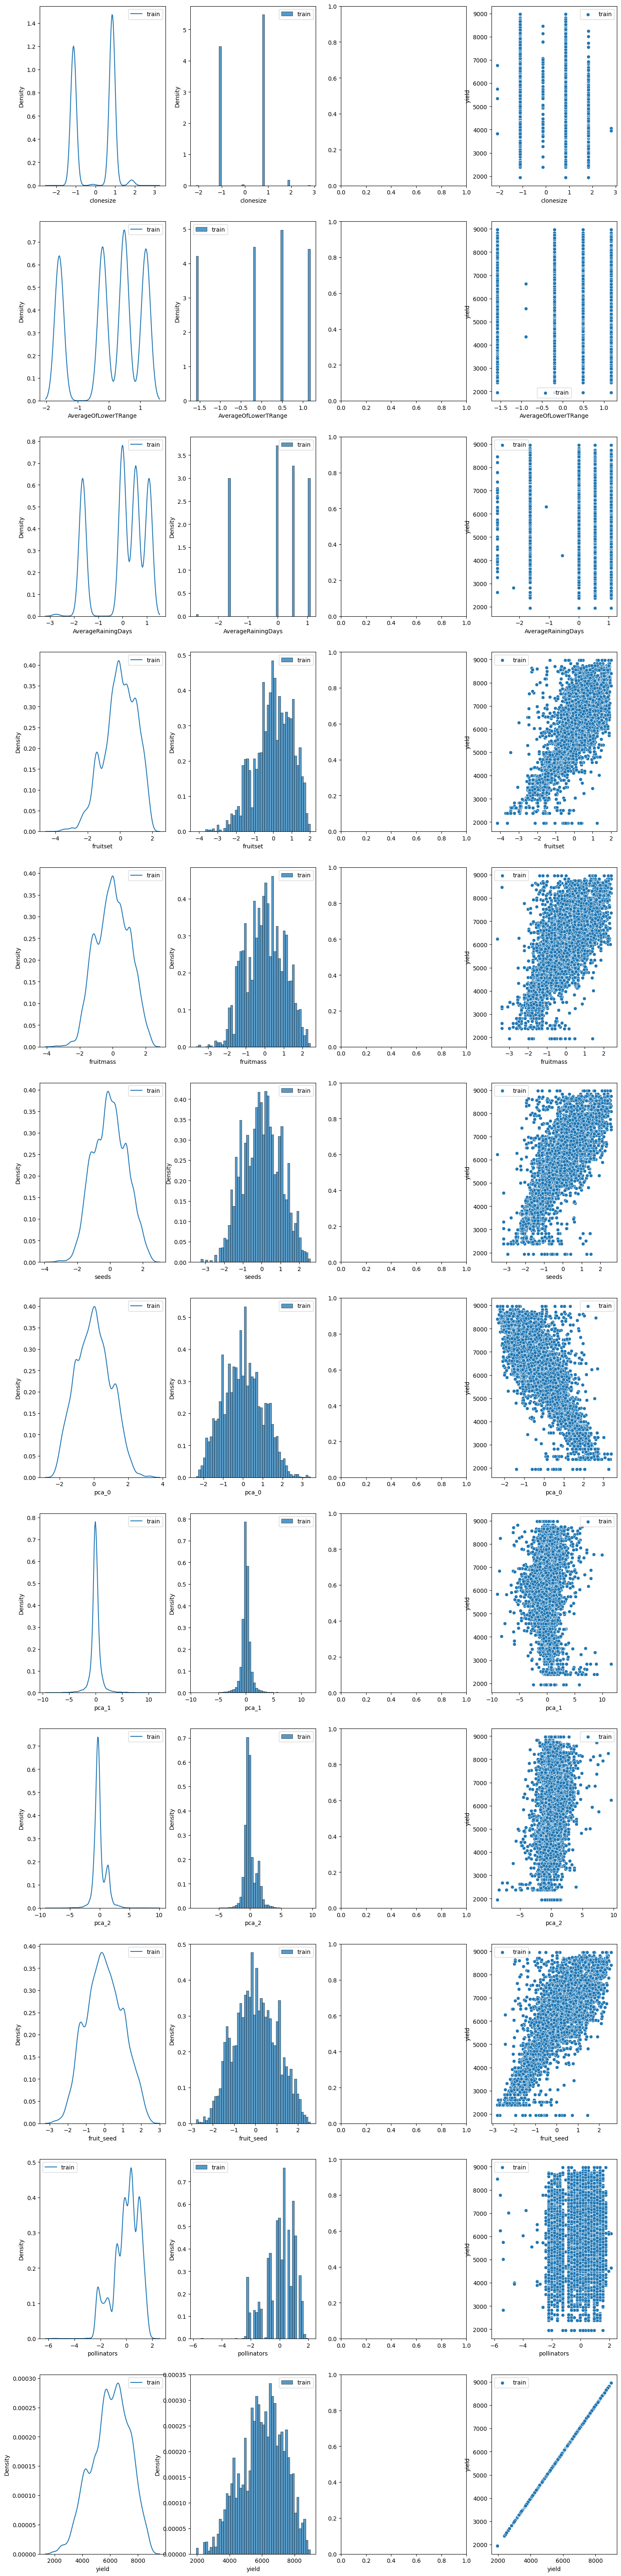

In [ ]:
fig, axes = plt.subplots(nrows=len(data_train.select_dtypes(include='number').columns), ncols=4, figsize=(18, 80))
axes = axes.flatten()

i = 0
for col in data_train.select_dtypes(include='number').columns:
    sns.kdeplot(data_train[col], label='train', ax=axes[i], fill=False)
    sns.histplot(data_train[col], label='train', ax=axes[i + 1], stat="density", bins=50)

    sns.scatterplot(x=col, y="yield", label='train', ax=axes[i + 3], data=data_train)

    axes[i].legend()
    axes[i + 1].legend()
    axes[i + 3].legend()
    i += 4

plt.show()

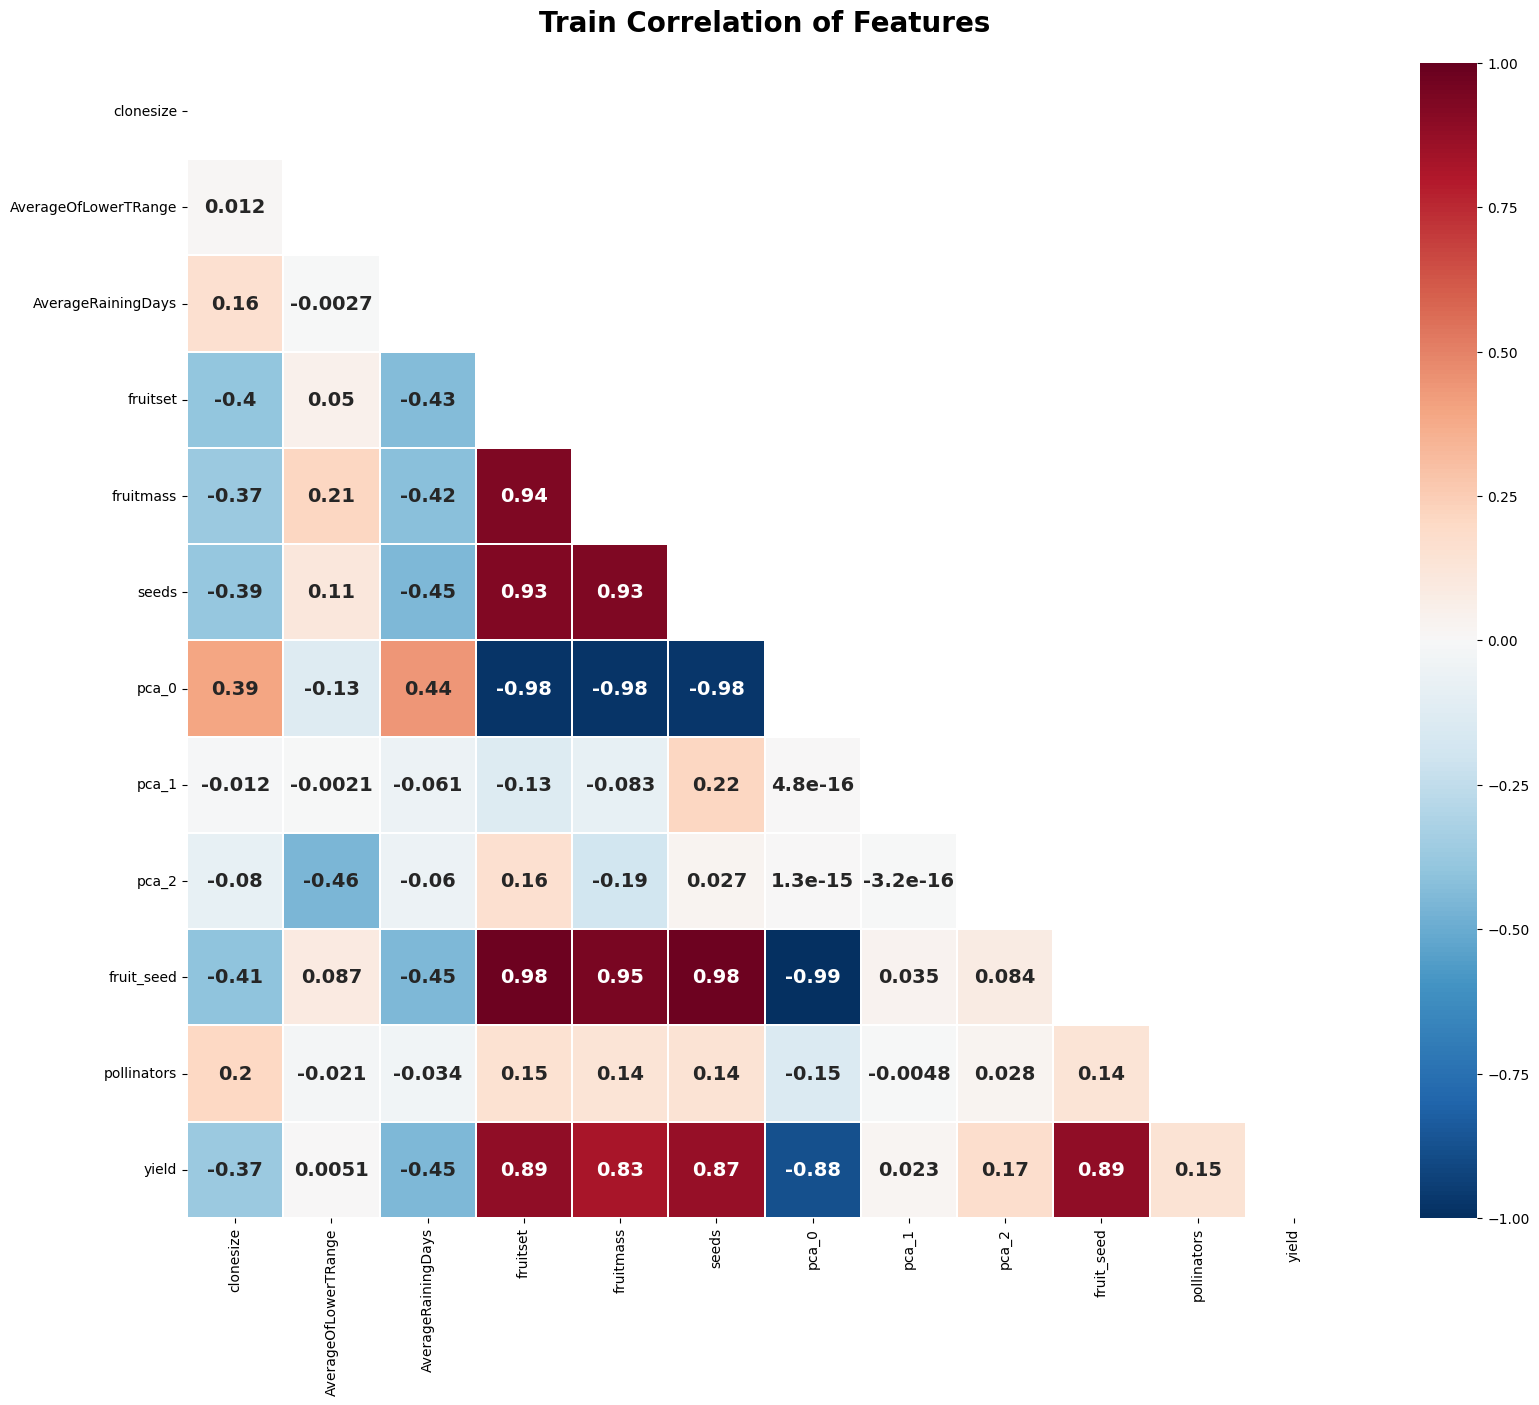

In [ ]:
def plot_heatmap(df, title):
    # Create a mask for the diagonal elements
    mask = np.zeros_like(df.astype(float).corr())
    mask[np.triu_indices_from(mask)] = True

    # Set the colormap and figure size
    colormap = plt.cm.RdBu_r
    plt.figure(figsize=(20, 15))

    # Set the title and font properties
    plt.title(f'{title} Correlation of Features', fontweight='bold', y=1.02, size=20)

    # Plot the heatmap with the masked diagonal elements
    sns.heatmap(df.astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1.0, 
                square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 14, "weight": "bold"},
                mask=mask)

plot_heatmap(data_train, title='Train')

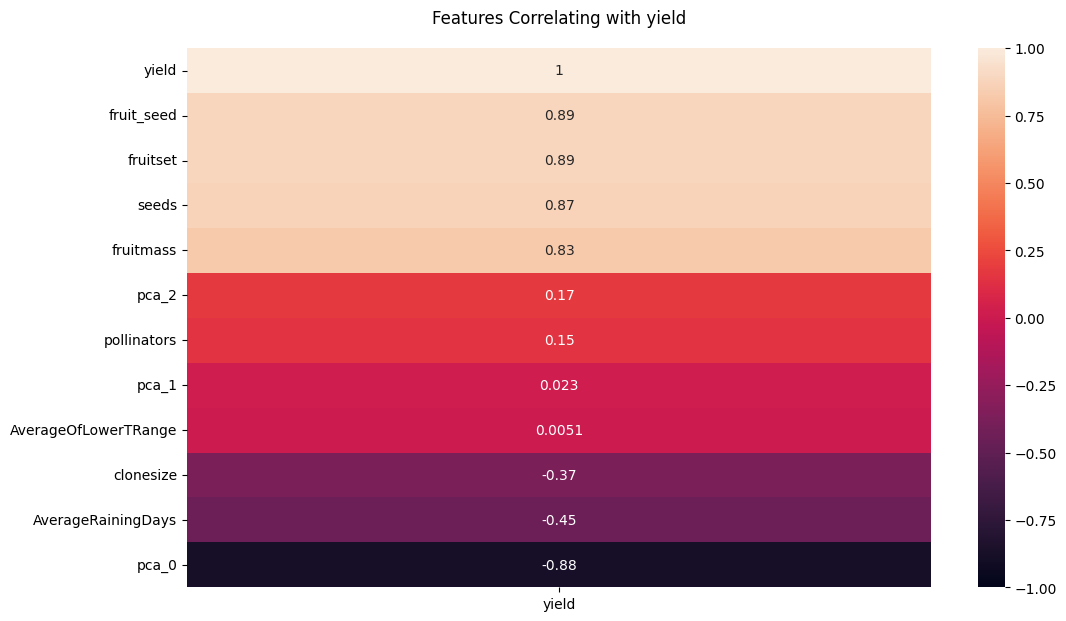

In [ ]:
plt.figure (figsize = (12, 7), dpi = 100)
heatmap = sns.heatmap (data_train.corr()[['yield']].sort_values (by = 'yield', ascending = False), vmin = -1, vmax = 1, annot = True)
heatmap.set_title ('Features Correlating with yield', fontdict = {'fontsize':12}, pad = 18);

<Axes: ylabel='Frequency'>

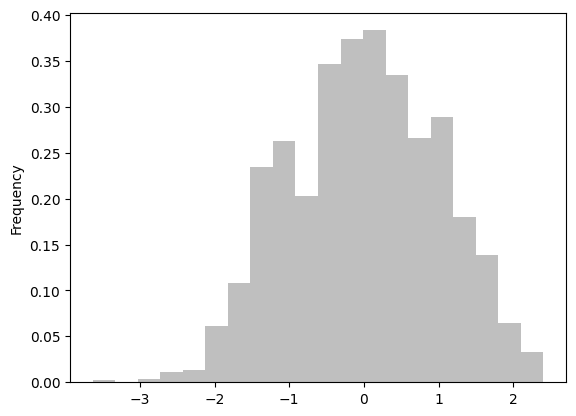

In [ ]:
data_train.fruitmass.plot(kind='hist', density=1, bins=20, stacked=False, alpha=.5, color='grey')

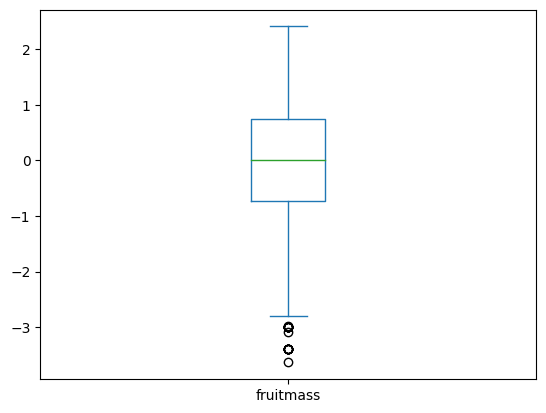

In [ ]:
_, bp = data_train.fruitmass.plot.box(return_type='both')


In [ ]:
# data_train = data_train[data_train['seeds'] > 25]
# data_train = data_train[data_train['fruitmass'] > 0.35]
# data_train = data_train[data_train['fruitset'] > 0.3]

In [ ]:
outliers = [flier.get_ydata() for flier in bp["fliers"]][0]
data_train[data_train.fruitmass.isin(outliers)]

clonesize  AverageOfLowerTRange  AverageRainingDays  fruitset  \
1160    1.836300              1.176280            0.546134 -3.618721   
1409    1.836300              0.485618            1.094527 -3.406585   
1647   -1.116704              1.176280            1.094527 -2.176700   
2075    0.851965             -1.586368            1.094527 -3.618721   
2650    1.836300              1.176280           -0.002260 -2.101574   
4226    1.836300              1.176280            1.094527 -3.586972   
4419    0.851965              0.485618            1.094527 -3.618721   
4632   -0.132369              0.485618           -2.744226 -2.301782   
4864    0.851965              0.485618           -0.002260 -3.406585   
5456    0.851965             -0.205044            1.094527 -3.618721   
6549   -0.132369              0.485618           -2.744226  0.079777   
7049    0.851965              0.485618            0.546134 -3.234446   
7520    1.836300             -1.586368            1.094527 -3.618721   
7542    1.836300              0.485618            1.094527 -3.406585   
8581    1.836300              1.176280            1.094527 -3.618721   
10294   0.851965             -1.586368            1.094527 -2.186903   
10538   1.836300             -0.205044            0.546134 -2.291008   
10792  -1.116704              1.176280            1.094527 -3.618721   
11514   1.836300              0.485618            1.094527 -3.618721   
12399   0.851965              1.176280            0.546134 -2.300271   
14048   0.851965              1.176280            1.094527 -3.406585   
14486   0.851965              1.176280            1.094527 -2.451007   
14880  -1.116704              1.176280            1.094527 -3.618721   

       fruitmass     seeds     pca_0     pca_1     pca_2  fruit_seed  \
1160   -3.003017 -2.938342  3.260722  1.321277 -1.569724   -2.784379   
1409   -3.397557 -3.163562  3.399753  0.702491  0.067929   -2.750081   
1647   -3.397557 -2.056730  2.603184  1.764203  3.720781   -1.952123   
2075   -3.003017 -2.938342  3.260722  1.321277 -1.569724   -2.784379   
2650   -2.978671 -2.759294  2.673782 -0.987445  2.349484   -2.131921   
4226   -3.003017 -2.938342  3.249890  1.262216 -1.487797   -2.771865   
4419   -3.003017 -2.938342  3.260722  1.321277 -1.569724   -2.784379   
4632   -3.397557 -1.951966  2.610185  2.313948  3.443360   -1.978127   
4864   -3.397557 -3.163562  3.399753  0.702491  0.067929   -2.750081   
5456   -3.003017 -2.938342  3.260722  1.321277 -1.569724   -2.784379   
6549   -3.635347 -3.494396  2.404058 -6.508729  9.637109   -1.575009   
7049   -3.397557 -3.163562  3.341019  0.382259  0.512135   -2.684765   
7520   -3.003017 -2.938342  3.260722  1.321277 -1.569724   -2.784379   
7542   -3.397557 -3.163562  3.399753  0.702491  0.067929   -2.750081   
8581   -3.003017 -2.938342  3.260722  1.321277 -1.569724   -2.784379   
10294  -3.397557 -2.095081  2.619726  1.667120  3.677850   -1.968186   
10538  -3.087203 -2.119449  2.557577  1.427203  2.464363   -2.022066   
10792  -3.003017 -2.938342  3.260722  1.321277 -1.569724   -2.784379   
11514  -3.003017 -2.938342  3.260722  1.321277 -1.569724   -2.784379   
12399  -3.397557 -3.163562  3.022277 -1.355591  2.922768   -2.330302   
14048  -3.397557 -3.163562  3.399753  0.702491  0.067929   -2.750081   
14486  -3.397557 -2.095081  2.709839  2.158435  2.996330   -2.086832   
14880  -3.003017 -2.938342  3.260722  1.321277 -1.569724   -2.784379   

       pollinators       yield  
1160     -2.227078  2384.72892  
1409     -1.633196  2605.69676  
1647     -1.831157  3322.94620  
2075     -0.049513  1945.53061  
2650     -2.227078  3511.53790  
4226     -1.633196  2379.90521  
4419      0.346408  1945.53061  
4632     -5.790366  8465.88563  
4864     -1.633196  2605.69676  
5456      0.544369  1945.53061  
6549     -5.592405  6239.53349  
7049     -2.227078  2384.72892  
7520     -2.227078  1945.53061  
7542     -2.227078  2605.69676  
8581     -2.227078  1945.53061  
10294     1.138250  3

In [ ]:
import numpy as np
from scipy import stats

def grubbs_stat(y):
    std_dev = np.std(y)
    avg_y = np.mean(y)
    abs_val_minus_avg = abs(y - avg_y)
    max_of_deviations = max(abs_val_minus_avg)
    max_ind = np.argmax(abs_val_minus_avg)
    Gcal = max_of_deviations / std_dev
    print(f"Grubbs Statistics Value: {Gcal}")
    return Gcal, max_ind

def calculate_critical_value(size, alpha):
    t_dist = stats.t.ppf(1 - alpha / (2 * size), size - 2)
    numerator = (size - 1) * np.sqrt(np.square(t_dist))
    denominator = np.sqrt(size) * np.sqrt(size - 2 + np.square(t_dist))
    critical_value = numerator / denominator
    print(f"Grubbs Critical Value: {critical_value}")
    return critical_value

def check_G_values(Gs, Gc, inp, max_index):
    if Gs > Gc:
        print(f"{inp[max_index]} is an outlier")
    else:
        print(f"{inp[max_index]} is not an outlier")

def ESD_test(input_series, alpha, max_outliers):
    for iteration in range(max_outliers):
        Gcritical = calculate_critical_value(len(input_series), alpha)
        Gstat, max_index = grubbs_stat(input_series)
        check_G_values(Gstat, Gcritical, input_series, max_index)
        input_series = np.delete(input_series, max_index)

In [ ]:
Gcritical = calculate_critical_value(len(data_train.fruitset), 0.05)
Gstat, max_index = grubbs_stat(data_train.fruitset)
check_G_values(Gstat, Gcritical, data_train.fruitset, max_index)
ESD_test(np.array(data_train.fruitset), 0.05, 3)

Grubbs Critical Value: 4.651496856922705
Grubbs Statistics Value: 4.167509545966962
-4.167509545966962 is not an outlier
Grubbs Critical Value: 4.651496856922705
Grubbs Statistics Value: 4.167509545966962
-4.167509545966962 is not an outlier
Grubbs Critical Value: 4.651483286395911
Grubbs Statistics Value: 3.7149034513882833
-3.712641495272114 is not an outlier
Grubbs Critical Value: 4.651469714926992
Grubbs Statistics Value: 3.622692680456365
-3.6187208875988457 is not an outlier


In [ ]:
data_train = data_train.reset_index()
data_train = data_train.drop(['index'], axis=1)
# data_train['yield'] = data_train['yield'].astype(int)

In [ ]:
data_train

clonesize  AverageOfLowerTRange  AverageRainingDays  fruitset  \
0       0.851965             -1.586368            0.546134 -1.044938   
1       0.851965             -1.586368            0.546134 -0.777454   
2      -1.116704              0.485618            0.546134  0.674659   
3      -1.116704             -0.205044            0.546134  0.850087   
4       0.851965             -0.205044            0.546134  1.034261   
...          ...                   ...                 ...       ...   
15284  -1.116704             -0.205044           -0.002260  0.720029   
15285  -1.116704              0.485618            1.094527 -1.993998   
15286   0.851965             -0.205044            1.094527 -1.078051   
15287   0.851965             -1.586368            0.546134  0.530056   
15288   0.851965             -0.205044           -0.002260 -0.143358   

       fruitmass     seeds     pca_0     pca_1     pca_2  fruit_seed  \
0      -0.783260 -0.918905  0.936905  0.071113 -0.736301   -1.016160   
1      -0.661588 -0.572230  0.686036  0.481603 -0.262269   -0.739988   
2       0.656157  0.540029 -0.638141 -0.381528 -0.000583    0.596922   
3       0.852832  0.819312 -0.860261 -0.090699 -0.019065    0.844748   
4       1.285628  1.071598 -1.156792 -0.171616 -0.737493    1.090985   
...          ...       ...       ...       ...       ...         ...   
15284   0.803468  1.086971 -0.890181  1.018516 -0.090209    0.892323   
15285  -1.577126 -1.661521  1.784684  0.509673 -1.116943   -1.746579   
15286  -0.803777 -0.959051  0.968881  0.035005 -0.777363   -1.048478   
15287  -0.335372  0.126345 -0.109372 -0.214852  2.432114    0.310096   
15288   0.000623 -0.265500  0.139117 -0.537531 -0.486744   -0.259491   

       pollinators       yield  
0         0.346408  4476.81146  
1        -0.643394  5548.12201  
2         0.742329  6869.77760  
3        -0.247473  6880.77590  
4         0.940289  7479.93417  
...            ...         ...  
15284    -1.435236  7667.83619  
15285    -1.831157  3680.56025  
15286    -0.049513  4696.44394  
15287     0.940289  6772.93347  
15288    -0.049513  5867.99722  

[15289 rows x 12 columns]

In [ ]:
# dat = data_train[data_train['seeds'] > 25]

In [ ]:
# dat = data_train.query('clonesize != 5 and clonesize != 0 and clonesize != 2')
# dat = dat.query('honeybee != 3')
# # dat = dat.query('bumbles != 9 and bumbles != 3 and bumbles != 4 and bumbles != 6')
# # dat = dat.query('andrena != 11 and andrena != 16 and andrena != 6 and andrena != 13 and andrena != 10 and andrena != 3')
# dat = dat.query('osmia != 4 and osmia != 15 and osmia != 14')
# # dat = dat.query('MaxOfUpperTRange != 5 and MaxOfUpperTRange != 3')
dat = data_train.drop(columns=['AverageOfLowerTRange'])

In [ ]:
print("Duplicated Data:",data_train.duplicated().sum())
data_train = data_train.drop_duplicates()

Duplicated Data: 10


In [ ]:
X = data_train.drop(columns=['yield'])
y = data_train['yield']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [ ]:
# from sklearn import model_selection

In [ ]:
# config = {'SEED': 42,
#             'FOLDS': 10,
#             'N_ESTIMATORS': 2000,
#             'EXP_NUM': '3',
#             'COMBINE': True,
#             'KFOLD': True,
#             'COL_DROP': [ 'RainingDays']}


# base_params = {'n_jobs': -1,
#                 'learning_rate': 0.04,
#                 'max_bin': 1000,
#                 'colsample_bytree': .8,
#                 'subsample': .7, 
#                 'bagging_freq': 1,
#                 'objective': 'regression_l1',
#                 'metric': 'mae',
#                 'early_stopping_rounds': 200,
#                 'verbosity': -1}

# cv = model_selection.RepeatedKFold(n_repeats=3, n_splits=config['FOLDS'],  random_state=config['SEED'])
# cv

In [ ]:
# X = X_train
# y = y_train

# def objective(trial):
#     params = {
#         'n_estimators': 1000,
#         'max_depth': trial.suggest_int('max_depth', 3, 20),
#         'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
#         'bootstrap': True,
#         'random_state': 42
#     }
#     rf = RandomForestRegressor(**params)
#     kf = KFold(n_splits=5, shuffle=True, random_state=42)
#     mae_list = []
#     for train_index, test_index in kf.split(X):
#         X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#         y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#         rf.fit(X_train, y_train)
#         y_pred = rf.predict(X_test)
#         mae = mean_absolute_error(y_test, y_pred)
#         mae_list.append(mae)
#     return np.mean(mae_list)

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=1)

In [ ]:
# X = X_train
# y = y_train

# def objective(trial):
#     params = {
#         'n_estimators': 1000,
#         'depth': trial.suggest_int('depth', 3, 12),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
#         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10.0),
#         'random_strength': trial.suggest_uniform('random_strength', 0.01, 1.0),
#         'max_bin': trial.suggest_int('max_bin', 50, 500),
#         'od_wait': trial.suggest_int('od_wait', 10, 100),
#         'grow_policy': 'Lossguide',
#         'bootstrap_type': 'Bayesian',
#         'od_type': 'Iter',
#         'eval_metric': 'MAE',
#         'loss_function': 'MAE',
#         'random_state': 42
#     }
#     cb = CatBoostRegressor(**params)
#     kf = KFold(n_splits=5, shuffle=True, random_state=42)
#     mae_list = []
#     for train_index, test_index in kf.split(X):
#         X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#         y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#         cb.fit(X_train, y_train, verbose=False)
#         y_pred = cb.predict(X_test)
#         mae = mean_absolute_error(y_test, y_pred)
#         mae_list.append(mae)
#     return np.mean(mae_list)

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=1)

In [ ]:
from tqdm import tqdm_notebook as tqdm

In [ ]:
models = []
# m = 400
# r = 600
# for j in tqdm(range(100, 1601, 100)):
for i in tqdm(range(5)):
    model = CatBoostRegressor(grow_policy = 'Lossguide', bootstrap_type = 'Bayesian', od_type = 'Iter', eval_metric = 'MAE', loss_function = 'MAE', random_state = 42, 
                            n_estimators = 5000, depth = 16, learning_rate = 0.01)
    model.fit(X_train, y_train)

    # preds_val = model.predict(X_valid)
    # mae = mean_absolute_error(y_valid, preds_val)
    # print("MAE:", mae)
    # rmse = mean_squared_error(y_valid, preds_val) ** 0.5 
    # print("RMSE:", rmse)

    models.append(model)

    models_avrg = sum_models(models, 
                            weights=[1.0/len(models)] * len(models))

    preds_val = models_avrg.predict(X_valid)
    mae = mean_absolute_error(y_valid, preds_val)
    print("MAE:", mae)
    rmse = mean_squared_error(y_valid, preds_val) ** 0.5 
    print("RMSE:", rmse)
        # if mae < m and r > rmse:
        #     m = mae
        #     r = rmse
        #     g = j
print(m, r, g)

<ipython-input-27-b7a93f6843b9>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(5)):


  0%|          | 0/5 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
3:	learn: 1060.5688640	total: 54ms	remaining: 1m 7s
4:	learn: 1052.0162058	total: 67.7ms	remaining: 1m 7s
5:	learn: 1043.6155962	total: 84.9ms	remaining: 1m 10s
6:	learn: 1036.2816108	total: 94.4ms	remaining: 1m 7s
7:	learn: 1028.8239459	total: 103ms	remaining: 1m 4s
8:	learn: 1021.2258226	total: 115ms	remaining: 1m 3s
9:	learn: 1013.8635951	total: 124ms	remaining: 1m 1s
10:	learn: 1006.2590969	total: 135ms	remaining: 1m 1s
11:	learn: 998.8566275	total: 145ms	remaining: 1m
12:	learn: 991.5272696	total: 165ms	remaining: 1m 3s
13:	learn: 984.0231651	total: 178ms	remaining: 1m 3s
14:	learn: 977.3309521	total: 188ms	remaining: 1m 2s
15:	learn: 970.6628370	total: 198ms	remaining: 1m 1s
16:	learn: 963.9206072	total: 206ms	remaining: 1m
17:	learn: 957.3254898	total: 217ms	remaining: 1m
18:	learn: 950.6617294	total: 227ms	remaining: 59.6s
19:	learn: 944.5278602	total: 237ms	remaining: 59.1s
20:	learn: 937.6150110	total: 247ms	remaining: 58.7s


In [ ]:
preds_val = models_avrg.predict(X_valid)
mae = mean_absolute_error(y_valid, preds_val)
print("MAE:", mae)
rmse = mean_squared_error(y_valid, preds_val) ** 0.5 
print("RMSE:", rmse)
#MAE: 333.31733393307996
# RMSE: 537.8295660050986
# 341.08078463690833

MAE: 332.7690961507012
RMSE: 541.1457256381804


In [ ]:
# X = X_train
# y = y_train

# def objective(trial):
#     params = {
#         'n_estimators': 1000,
#         'num_leaves': trial.suggest_int('num_leaves', 8, 128),
#         'max_depth': trial.suggest_int('max_depth', 3, 15),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
#         'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-9, 10.0),
#         'objective': 'regression_l1',
#         'metric': 'mean_absolute_error',
#         'boosting_type': 'gbdt',
#         'device': 'cpu',
#         'random_state': 42
#     }
    
#     lgbm = lgb.LGBMRegressor(**params)
#     kf = KFold(n_splits=5, shuffle=True, random_state=42)
#     mae_list = []
#     for train_index, test_index in kf.split(X):
#         X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#         y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#         lgbm.fit(X_train, y_train)
#         y_pred = lgbm.predict(X_test)
#         mae = mean_absolute_error(y_test, y_pred)
#         mae_list.append(mae)
#     return np.mean(mae_list)

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=1)

In [ ]:
# data_train = data_train[data_train['seeds'] > 25]
# data_train = data_train[data_train['fruitmass'] > 0.35]
# data_train = data_train[data_train['fruitset'] > 0.3]
# data_train = data_train.reset_index()
# data_train = data_train.drop(['index'], axis=1)
# print("Duplicated Data:",data_train.duplicated().sum())
# data_train = data_train.drop_duplicates()
# X = data_train.drop(columns=['yield'])
# y = data_train['yield']

In [ ]:
X

clonesize  AverageOfLowerTRange  AverageRainingDays  fruitset  \
0       0.851965             -1.586368            0.546134 -1.044938   
1       0.851965             -1.586368            0.546134 -0.777454   
2      -1.116704              0.485618            0.546134  0.674659   
3      -1.116704             -0.205044            0.546134  0.850087   
4       0.851965             -0.205044            0.546134  1.034261   
...          ...                   ...                 ...       ...   
15284  -1.116704             -0.205044           -0.002260  0.720029   
15285  -1.116704              0.485618            1.094527 -1.993998   
15286   0.851965             -0.205044            1.094527 -1.078051   
15287   0.851965             -1.586368            0.546134  0.530056   
15288   0.851965             -0.205044           -0.002260 -0.143358   

       fruitmass     seeds     pca_0     pca_1     pca_2  fruit_seed  \
0      -0.783260 -0.918905  0.936905  0.071113 -0.736301   -1.016160   
1      -0.661588 -0.572230  0.686036  0.481603 -0.262269   -0.739988   
2       0.656157  0.540029 -0.638141 -0.381528 -0.000583    0.596922   
3       0.852832  0.819312 -0.860261 -0.090699 -0.019065    0.844748   
4       1.285628  1.071598 -1.156792 -0.171616 -0.737493    1.090985   
...          ...       ...       ...       ...       ...         ...   
15284   0.803468  1.086971 -0.890181  1.018516 -0.090209    0.892323   
15285  -1.577126 -1.661521  1.784684  0.509673 -1.116943   -1.746579   
15286  -0.803777 -0.959051  0.968881  0.035005 -0.777363   -1.048478   
15287  -0.335372  0.126345 -0.109372 -0.214852  2.432114    0.310096   
15288   0.000623 -0.265500  0.139117 -0.537531 -0.486744   -0.259491   

       pollinators  
0         0.346408  
1        -0.643394  
2         0.742329  
3        -0.247473  
4         0.940289  
...            ...  
15284    -1.435236  
15285    -1.831157  
15286    -0.049513  
15287     0.940289  
15288    -0.049513  

[15279 rows x 11 columns]

In [ ]:
# params = { 'n_jobs': -1, 'random_state': 42, 'objective': 'regression_l1', 'metric': 'mae', 'num_leaves': 58,
#                             'learning_rate': 0.023640239702728376, 'min_child_samples': 14, 'colsample_bytree': 0.7006991908929474,
#                             'n_estimators': 663, 'reg_alpha': 0.6469675138495181, 'reg_lambda': 0.14870311599361627}

# lgbm = lgb.LGBMRegressor(**params)
# kf = KFold(n_splits=10, shuffle=True, random_state=42)
# mae_list = []

# lgbm.fit(X, y)
# y_pred = lgbm.predict(X_valid)
# mae = mean_absolute_error(y_valid, y_pred)
# mae_list.append(mae)
# np.mean(mae_list)


# pred = lgbm.predict(X_valid)
# mae = mean_absolute_error(y_valid, pred)
# print("MAE:", mae)
# rmse = mean_squared_error(y_valid, pred) ** 0.5 
# print("RMSE:", rmse)

LGBMRegressor(colsample_bytree=0.7006991908929474,
              learning_rate=0.023640239702728376, metric='mae',
              min_child_samples=14, n_estimators=663, num_leaves=58,
              objective='regression_l1', random_state=42,
              reg_alpha=0.6469675138495181, reg_lambda=0.14870311599361627)

In [ ]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

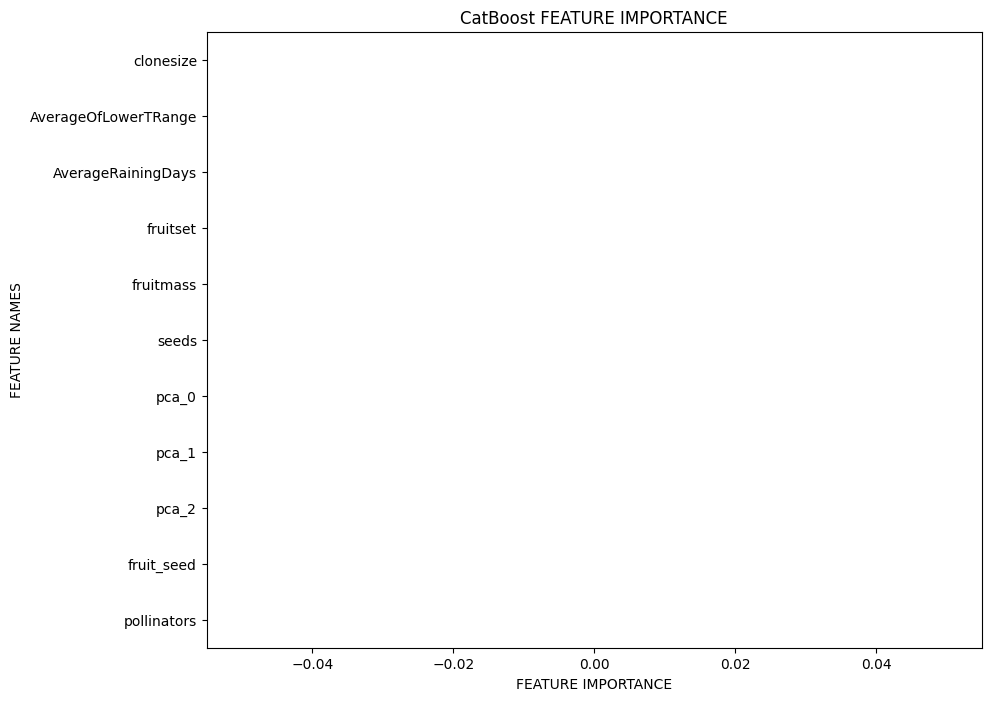

In [ ]:
plot_feature_importance(models_avrg.feature_importances_,X_train.columns,'CatBoost ')
# plot_feature_importance(lgbm.feature_importances_,X_train.columns,'LGBMRegressor ')
# plot_feature_importance(rf.feature_importances_,X_train.columns,'XGBRegressor ')

In [ ]:
data_test = pd.read_csv('test.csv')
display(data_test.head())
data_test.info()

id  clonesize  honeybee  bumbles  andrena  osmia  MaxOfUpperTRange  \
0  15289       25.0      0.25     0.25     0.25   0.25              86.0   
1  15290       12.5      0.25     0.25     0.75   0.63              94.6   
2  15291       12.5      0.25     0.25     0.63   0.63              86.0   
3  15292       25.0      0.50     0.38     0.38   0.63              86.0   
4  15293       37.5      0.75     0.25     0.25   0.25              94.6   

   MinOfUpperTRange  AverageOfUpperTRange  MaxOfLowerTRange  MinOfLowerTRange  \
0              52.0                  71.9              62.0              30.0   
1              57.2                  79.0              68.2              33.0   
2              52.0                  71.9              62.0              30.0   
3              52.0                  71.9              62.0              30.0   
4              57.2                  79.0              68.2              33.0   

   AverageOfLowerTRange  RainingDays  AverageRainingDays  fruitset  fruitmass  \
0                  50.8         24.0                0.39  0.399367   0.408088   
1                  55.9          1.0                0.10  0.488048   0.442866   
2                  50.8         16.0                0.26  0.583379   0.487057   
3                  50.8         16.0                0.26  0.433014   0.422847   
4                  55.9         24.0                0.39  0.360996   0.388860   

       seeds  
0  31.394569  
1  36.846956  
2  40.037644  
3  33.116091  
4  29.558019

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10194 entries, 0 to 10193
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10194 non-null  int64  
 1   clonesize             10194 non-null  float64
 2   honeybee              10194 non-null  float64
 3   bumbles               10194 non-null  float64
 4   andrena               10194 non-null  float64
 5   osmia                 10194 non-null  float64
 6   MaxOfUpperTRange      10194 non-null  float64
 7   MinOfUpperTRange      10194 non-null  float64
 8   AverageOfUpperTRange  10194 non-null  float64
 9   MaxOfLowerTRange      10194 non-null  float64
 10  MinOfLowerTRange      10194 non-null  float64
 11  AverageOfLowerTRange  10194 non-null  float64
 12  RainingDays           10194 non-null  float64
 13  AverageRainingDays    10194 non-null  float64
 14  fruitset              10194 non-null  float64
 15  fruitmass          

In [ ]:
# X = data_test.drop(['id', 'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange', 'MaxOfLowerTRange', 'AverageOfLowerTRange', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds'], axis=1)
# X = data_test.drop(['id','MinOfLowerTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange', 'MaxOfLowerTRange', 'MaxOfUpperTRange', 'RainingDays'], axis=1)

In [ ]:
unique_targets = np.unique(data_train["yield"])

In [ ]:
final_prediction = models_avrg.predict(df_test)
test_preds = [min(unique_targets, key = lambda x: abs(x - pred)) for pred in final_prediction]
final_test = pd.DataFrame({'id' : data_test['id'], 'yield' : test_preds})
final_test

id       yield
0      15289  4334.84122
1      15290  5996.07855
2      15291  7290.10652
3      15292  4740.01505
4      15293  3828.16556
...      ...         ...
10189  25478  5514.66748
10190  25479  5711.85174
10191  25480  6491.22353
10192  25481  4493.64409
10193  25482  7215.40971

[10194 rows x 2 columns]

In [ ]:
from google.colab import files
final_test.to_csv('output.csv', encoding = 'utf-8-sig' , index = False) 
files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>